In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class ReqState(TypedDict):
    req_actor: List[str]
    req_names: List[str]
    req_purpose: List[str]
    req_importance: List[str]
    req_level: List[str]
    req_function: List[str]
    req_process: List[str]
    req_screen: List[str]
    req_security: List[str]
    req_perform: List[str]
    req_data: List[str]


In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    collection_name='req-tax',
    embedding_function=embedding,
    persist_directory='../req-tax'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o')

In [ ]:
from langchain_core.prompts import PromptTemplate

req_level_prompt = PromptTemplate.from_template(
    """당신은 it기업에서 10년째 에이스 촉방받는 기획자입니다 주어진 Information을 가지고 
    요구사항 기능명에 맞는 난이도를 평가해주세요.
    출력은 반드시 [상, 중, 하]중 하나를 선택해서 출력해주세요.

    Information:
    {req_info}
    {name}
    {purpose}"""
    )
    
req_level_chain = req_level_prompt | llm   
def generate_req_level(state: ReqState) -> ReqState:
    """ 
    주어진 state를 기반으로 난이도를 평가합니다.
    
    Args:
        state (ReqState): req_actor, req_purpose, req_names를 참고합니다.
        
    Returns:
        ReqState: 기능 난이도를 추가한 state를 반환합니다.
    """
    results = []
    req_names = state["req_names"]
    req_purpose = state["req_purpose"]
    for name, purpose in zip(req_names, req_purpose):
        req_info = retriever.invoke(name)
        result = req_level_chain.invoke({'req_info' : req_info, 'name' : name, 'purpose' : purpose })
        results.append(result)
    return {'req_level': results}

In [ ]:
from langchain_core.prompts import PromptTemplate

req_importance_prompt = PromptTemplate.from_template(
    """당신은 it기업에서 10년째 에이스 촉방받는 기획자입니다 주어진 Information을 가지고 
    요구사항 기능명에 맞는 중요도를 평가해주세요.
    출력은 반드시 [상, 중, 하]중 하나를 선택해서 출력해주세요.

    Information:
    {req_info}
    {name}
    {purpose}"""
    )
    
req_importance_chain = req_importance_prompt | llm   
def generate_req_importance(state: ReqState) -> ReqState:
    """ 
    주어진 state를 기반으로 중요도를 평가합니다.
    
    Args:
        state (ReqState): req_actor, req_purpose, req_names를 참고합니다.
        
    Returns:
        ReqState: 기능 중요도 추가한 state를 반환합니다.
    """
    results = []
    req_names = state["req_names"]
    req_purpose = state["req_purpose"]
    for name, purpose in zip(req_names, req_purpose):
        req_info = retriever.invoke(name)
        result = req_importance_chain.invoke({'req_info' : req_info, 'name' : name, 'purpose' : purpose })
        results.append(result)
    return {'req_importance': results}

In [ ]:
from langchain_core.prompts import PromptTemplate

req_function_prompt = PromptTemplate.from_template(
    """당신은 it기업에서 10년째 에이스 촉방받는 기획자입니다 주어진 Information을 가지고 
    기능 요구상을 작성해주세요. 요구사항을 작성할 때는 10줄 이하로 간결하게 하지만 개발에 필요한 기능은
    다 담을 수 있게 작성하세요.

    Information:
    {req_info}
    {name}
    {purpose}"""
    )
    
req_function_chain = req_function_prompt | llm   
def generate_req_function(state: ReqState) -> ReqState:
    """ 
    주어진 state를 기반으로 기능 요구사항을 정의합니다.
    
    Args:
        state (ReqState): req_actor, req_purpose, req_names를 참고합니다.
        
    Returns:
        ReqState: 기능 요구사항을 추가한 state를 반환합니다.
    """
    results = []
    req_names = state["req_names"]
    req_purpose = state["req_purpose"]
    for name, purpose in zip(req_names, req_purpose):
        req_info = retriever.invoke(name)
        result = req_function_chain.invoke({'req_info' : req_info, 'name' : name, 'purpose' : purpose })
        results.append(result)
    return {'req_function': results}

In [ ]:
from langchain_core.prompts import PromptTemplate

req_process_prompt = PromptTemplate.from_template(
    """당신은 it기업에서 10년째 에이스 촉방받는 기획자입니다 주어진 Information을 가지고 
    요구사항에 맞는 프로세스 요구사항을 작성해 주세요. 프로세스를 작성할 때는 요구사항을 반영한 
    순서의 흐름을 작성하세요
    ex) function = 	(
    - 사용자는 '지갑 연결하기' 버튼을 통해 MetaMask 등 웹3 지갑을 연결할 수 있다. 
    - 지갑이 연결되면, 플랫폼은 사용자에게 고유한 메시지에 서명을 요청하여 소유권을 확인한다. 
    - 서명이 성공적으로 검증되면, 서버는 세션(Session) 또는 JWT(JSON Web Token)를 생성하여 로그인 상태를 유지한다.
    - 로그인된 사용자는 자신의 지갑 주소(단축 형태)와 프로필 이미지를 확인할 수 있다. 
    - 사용자는 '로그아웃' 버튼을 통해 언제든지 세션을 종료하고 연결을 해제할 수 있다. 
    - 브라우저 재접속 시, 유효한 세션이 있다면 자동으로 로그인 상태가 유지되어야 한다. )

    process = (
    1. (사용자) 헤더의 '지갑 연결하기' 버튼 클릭
    2. (시스템) 브라우저에 설치된 MetaMask 확장 프로그램 팝업 자동 실행
    3. (사용자) MetaMask에서 연결할 계정 선택 후 '연결' 승인
    4. (시스템) 지갑 주소 정보 수신 후, 백엔드에서 생성된 인증용 메시지 서명 요청
    5. (사용자) MetaMask에서 '서명' 버튼 클릭
    6. (시스템) 백엔드에서 서명 값 검증 후 유효하면 세션 생성 및 로그인 처리
    7. (시스템) 헤더 영역이 '로그인' 상태로 변경 (지갑 주소, 로그아웃 버튼 표시)
    )

    Information:
    {req_info}
    {actor}
    {name}
    {purpose}
    {function}
    """
    )
    
req_process_chain = req_process_prompt | llm   
def generqte_req_process(state: ReqState) -> ReqState:
    """ 
    주어진 state를 기반으로 기능 요구사항을 정의합니다.
    
    Args:
        state (ReqState): req_actor, req_purpose, req_names를 참고합니다.
        
    Returns:
        ReqState: 기능 요구사항을 추가한 state를 반환합니다.
    """
    results = []
    req_names = state["req_names"]
    req_purpose = state["req_purpose"]
    req_function = state["req_function"]
    req_actor = state["req_actor"]
    for actor, name, purpose, function  in zip(req_actor, req_names, req_purpose, req_function):
        req_info = retriever.invoke(name)
        result = req_process_chain.invoke({'req_info' : req_info, 'actor' : actor, 'name' : name, 'purpose' : purpose, 'function' : function , })
        results.append(result)
    return {'req_process': results}

In [9]:
from langgraph.graph import StateGraph
graph_builder = StateGraph(ReqState)


In [10]:
graph_builder.add_node('generate_req_level', generate_req_level)
graph_builder.add_node('generate_req_importance', generate_req_importance)
graph_builder.add_node('generate_req_function', generate_req_function)
graph_builder.add_node('generqte_req_process', generqte_req_process)


In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'generate_req_level')
graph_builder.add_edge(START, 'generate_req_importance')
graph_builder.add_edge(START, 'generate_req_function')
graph_builder.add_edge('generate_req_level', 'generqte_req_process')
graph_builder.add_edge('generate_req_importance', 'generqte_req_process')
graph_builder.add_edge('generate_req_function', 'generqte_req_process')
graph_builder.add_edge('generqte_req_process', END)

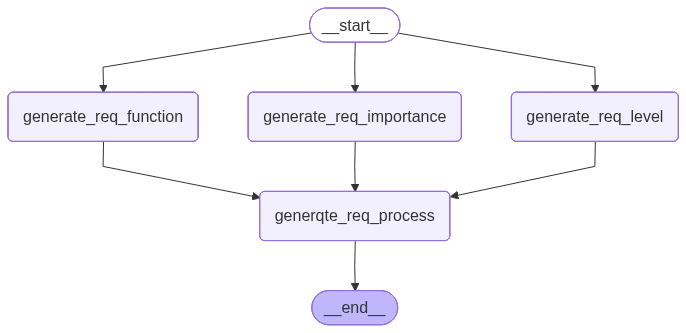

In [12]:
graph_jy= graph_builder.compile()
graph_jy